## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import IPython
import sys, os, array, time
import serial 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

**QUESTION:** Load dataset and display some lines of the csv file.

In [2]:
Raw_data = pd.read_excel('./ai4i2020.xlsx')
print(Raw_data.iloc[0])
print("---")
print(Raw_data.iloc[150])
print("---")


UDI                             1
Product ID                 M14860
Type                            M
Air temperature [K]         298.1
Process temperature [K]     308.6
Rotational speed [rpm]       1551
Torque [Nm]                  42.8
Tool wear [min]                 0
Machine failure                 0
TWF                             0
HDF                             0
PWF                             0
OSF                             0
RNF                             0
Name: 0, dtype: object
---
UDI                           151
Product ID                 L47330
Type                            L
Air temperature [K]         298.4
Process temperature [K]     308.3
Rotational speed [rpm]       1422
Torque [Nm]                  42.7
Tool wear [min]               186
Machine failure                 0
TWF                             0
HDF                             0
PWF                             0
OSF                             0
RNF                             0
Name: 150, dtype: obj

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

Machine failure
0    9661
1     339
Name: count, dtype: int64


Text(0.5, 1.0, 'failed and functionnal machines')

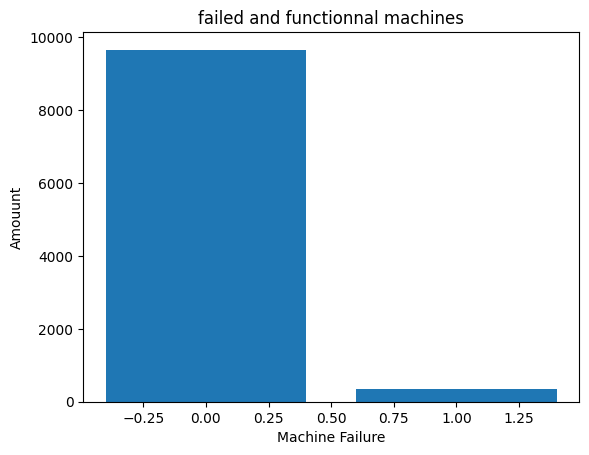

In [3]:
compte = Raw_data["Machine failure"].value_counts()
print(compte)
plt.bar(compte.index, compte.values)
plt.xlabel('Machine Failure')
plt.ylabel('Amouunt')
plt.title('failed and functionnal machines')


**ANALYSIS QUESTION:** What do you observe?

Much more working machine than dysfunctional ones.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

"Write here your response"

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

Text(0.5, 1.0, 'Amount of failure types')

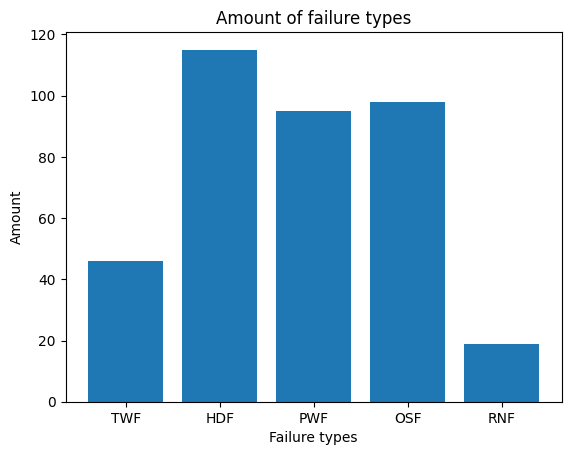

In [4]:
plt.bar(['TWF','HDF','PWF','OSF','RNF'],[Raw_data['TWF'].sum(),Raw_data['HDF'].sum(),Raw_data['PWF'].sum(),Raw_data['OSF'].sum(),Raw_data['RNF'].sum()])
plt.xlabel('Failure types')
plt.ylabel('Amount')
plt.title('Amount of failure types')

**ANALYSIS QUESTION:** What do you observe?

There are 3 principal failure types (HDF, PWF, OSF) and 3 less frequent failures (TWF, RNF)

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

C:\Users\rabie\AppData\Local\Temp\ipykernel_13676\1597477434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['No specific data'] = (~(filtered_data['TWF']==1) & ~(filtered_data['HDF']==1) & ~(filtered_data['PWF']==1) & ~(filtered_data['OSF']==1) & ~(filtered_data['RNF']==1) )


Text(0.5, 1.0, 'Amount of failure types for failed machines only')

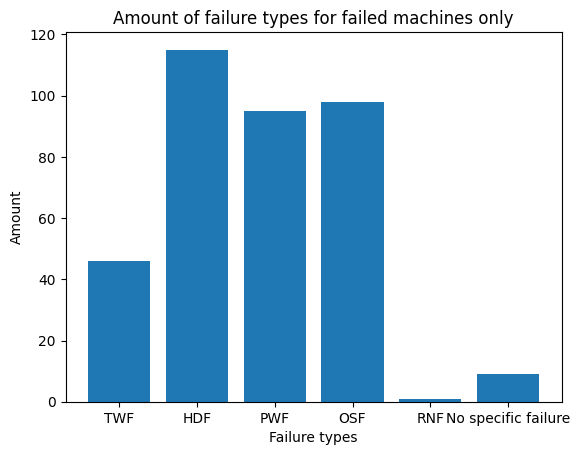

In [5]:

filtered_data = Raw_data[Raw_data['Machine failure']==1]
#print(filtered_data.iloc[0])
filtered_data['No specific data'] = (~(filtered_data['TWF']==1) & ~(filtered_data['HDF']==1) & ~(filtered_data['PWF']==1) & ~(filtered_data['OSF']==1) & ~(filtered_data['RNF']==1) )
#print(filtered_data)
#test = filtered_data[filtered_data['No specific data']==True]
#print(test)
plt.bar(['TWF','HDF','PWF','OSF','RNF','No specific failure'],[filtered_data['TWF'].sum(),filtered_data['HDF'].sum(),filtered_data['PWF'].sum(),filtered_data['OSF'].sum(),filtered_data['RNF'].sum(),filtered_data['No specific data'].sum()])
plt.xlabel('Failure types')
plt.ylabel('Amount')
plt.title('Amount of failure types for failed machines only')

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

Distribution remains identical except for RNF failure that seems very very low, we also observe that some machines failed even though no failure types were noticed.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [6]:
Raw_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

We get rid of RNF (random will not help us preidct), we also get rid of no specifi failure and we create a column oposite to machine failure, inpuits are the functionnal data and labels are the 4 types of failure and the opposite of machine failure

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [6]:
Raw_data["Functionnal"] = 1-Raw_data['Machine failure']
data_df = Raw_data.drop(['Type','UDI','Product ID','RNF', 'Machine failure'], axis=1)
print(data_df.iloc[0])
print("---")
data_inputs = data_df.iloc[:,0:5]
print(data_inputs.iloc[0])
print("---")
data_outputs = data_df.iloc[:,5:]
print(data_outputs.iloc[0])
X_train, X_test, Y_train, Y_test = train_test_split(data_inputs, data_outputs, test_size=0.3, random_state=42)
X_test,X_valid,Y_test,Y_valid = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
output_labels = data_outputs.columns.tolist()
print(output_labels)







Air temperature [K]         298.1
Process temperature [K]     308.6
Rotational speed [rpm]     1551.0
Torque [Nm]                  42.8
Tool wear [min]               0.0
TWF                           0.0
HDF                           0.0
PWF                           0.0
OSF                           0.0
Functionnal                   1.0
Name: 0, dtype: float64
---
Air temperature [K]         298.1
Process temperature [K]     308.6
Rotational speed [rpm]     1551.0
Torque [Nm]                  42.8
Tool wear [min]               0.0
Name: 0, dtype: float64
---
TWF            0
HDF            0
PWF            0
OSF            0
Functionnal    1
Name: 0, dtype: int64
['TWF', 'HDF', 'PWF', 'OSF', 'Functionnal']


**QUESTION** Code below the model architecture

In [7]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, ReLU, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# For input shape (100, 5)
inputs = Input(shape=(5,))  

# Dense layers with L2 regularization, ReLu activation and dropout rate of 25%
x = Dense(1024, kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)

x = Dense(512, kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)


x = Dense(256, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)


x = Dense(128, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)


x = Dense(64, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)


x = Dense(32, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)


outputs = Dense(5, activation='softmax')(x)

#Model defintion
unbalanced = tf.keras.Model(inputs=inputs, outputs=outputs, name="unbalanced")

unbalanced.summary()

unbalanced.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

#Training parameters
nb_epochs = 50
batch_size = 120

#Train the model
training_history = unbalanced.fit(X_train, Y_train,validation_data=(X_valid, Y_valid),epochs=nb_epochs,batch_size=batch_size)


Model: "unbalanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 181,765 (710.02 KB)

 Trainable params: 179,781 (702.27 KB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.2049 - loss: 2.4737 - val_accuracy: 0.0060 - val_loss: 3.3296
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3167 - loss: 2.2581 - val_accuracy: 0.0060 - val_loss: 2.8197
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4180 - loss: 2.1112 - val_accuracy: 0.0060 - val_loss: 2.9097
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5065 - loss: 1.9626 - val_accuracy: 0.2580 - val_loss: 2.2573
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6179 - loss: 1.7916 - val_accuracy: 0.7473 - val_loss: 1.8416
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6868 - loss: 1.6865 - val_accuracy: 0.8767 - val_loss: 1.6253
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7665 - loss: 1.5732 - val_accuracy: 0.9253 - val_loss: 1.4958
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8202 - loss: 1.4744 - val_accuracy: 0.9380 - v

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9519 - loss: 0.6435
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9604 - loss: 0.6316 
Performance on the TRAIN set, ACCURACY= 0.9527142643928528
Performance on the TEST set, ACCURACY= 0.95333331823349


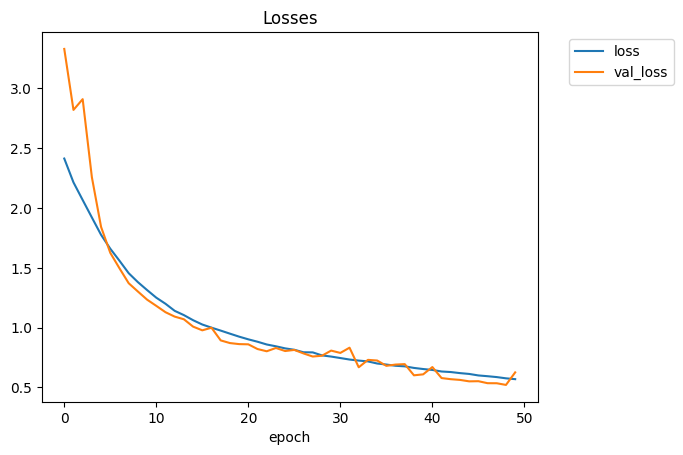

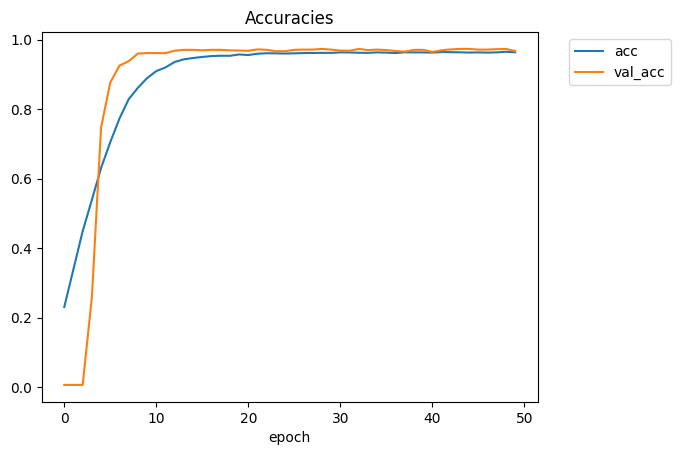

In [8]:
#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = unbalanced.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = unbalanced.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

def display_training_curves(training_history):
  #display loss
  plt.plot(training_history.history['loss'],label='loss')
  plt.plot(training_history.history['val_loss'], label='val_loss')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.title("Losses")
  plt.show()
  #display accuracy
  plt.plot(training_history.history['accuracy'],label='acc')
  plt.plot(training_history.history['val_accuracy'], label='val_acc')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.title("Accuracies")
  plt.show()
  
display_training_curves(training_history)



**QUESTION** Plot the confusion matrix and the classification report

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
(1500, 5)


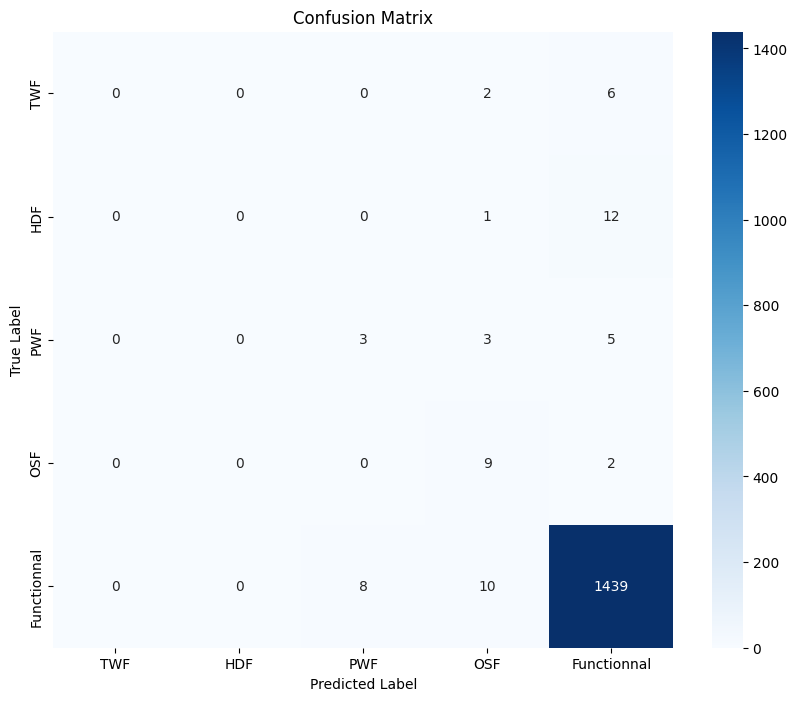

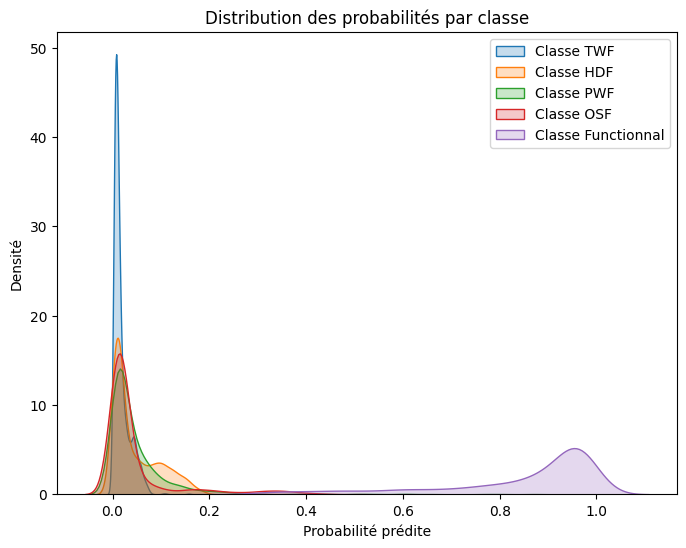

              precision    recall  f1-score   support

         TWF       0.00      0.00      0.00         8
         HDF       0.00      0.00      0.00        13
         PWF       0.27      0.27      0.27        11
         OSF       0.36      0.82      0.50        11
 Functionnal       0.98      0.99      0.99      1457

    accuracy                           0.97      1500
   macro avg       0.32      0.42      0.35      1500
weighted avg       0.96      0.97      0.96      1500



c:\Users\rabie\OneDrive\Bureau\ISMIN 2A\S8\Embeded_AI\embeded_ia\ai_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rabie\OneDrive\Bureau\ISMIN 2A\S8\Embeded_AI\embeded_ia\ai_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rabie\OneDrive\Bureau\ISMIN 2A\S8\Embeded_AI\embeded_ia\ai_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
import seaborn as sns


#Predictions
Y_pred_probs = unbalanced.predict(X_valid) # Get probability predictions
Y_pred = np.argmax(Y_pred_probs, axis=1) # Convert to class labels
Y_true = np.argmax(Y_valid, axis=1)
print(Y_valid.shape)

##Problème : on perd une classe ce qui empêche d'avoir une bonne matrice de confusion et d'obtenir le report => une classe ne serait pas représenté dans la Y_valid alors que la shape est bien (1500,5)


#Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=output_labels, yticklabels=output_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


#Probability distribution for each class
plt.figure(figsize=(8,6))
for i in range(5):
    sns.kdeplot(Y_pred_probs[:, i], label=f'Classe {output_labels[i]}', fill=True)

plt.xlabel("Probabilité prédite")
plt.ylabel("Densité")
plt.title("Distribution des probabilités par classe")
plt.legend()
plt.show()


#Report
report = classification_report(Y_true, Y_pred, target_names=output_labels)
print(report)

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





**ANALYSIS QUESTION** What do you observe? What can you conclude?

The class "functionnal" is much more represented in the data which leads the model to be efficient but only for this class and we unfortunately get much less information for other classes 

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight  

#I'll keep the same datasets but i'll use class wheights



y_train_labels = Y_train.idxmax(axis=1).astype('category').cat.codes
#Isolating labels
unique_classes = np.unique(y_train_labels)
#Class wheight computing
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_labels
)
#Wheight to dico
class_weight_dict = {int(cls): float(weight) for cls, weight in zip(unique_classes, class_weights)}
print(class_weight_dict)



{0: 0.207284572105419, 1: 15.555555555555555, 2: 25.0, 3: 22.580645161290324, 4: 36.8421052631579}


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [17]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, ReLU, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# For input shape (100, 5)
inputs = Input(shape=(5,))  

# Dense layers with L2 regularization, ReLu activation and dropout rate of 25%
x = Dense(1024, kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)

x = Dense(512, kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)


x = Dense(256, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)


x = Dense(128, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)


x = Dense(64, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)


x = Dense(32, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)


outputs = Dense(5, activation='softmax')(x)

#Model defintion
weighted = tf.keras.Model(inputs=inputs, outputs=outputs, name="unbalanced")

weighted.summary()

weighted.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])



#Training parameters
nb_epochs = 50
batch_size = 120

#Train the model
training_history_weighted = weighted.fit(X_train, Y_train,class_weight=class_weight_dict,validation_data=(X_valid, Y_valid),epochs=nb_epochs,batch_size=batch_size)


Model: "unbalanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 181,765 (710.02 KB)

 Trainable params: 179,781 (702.27 KB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5633 - loss: 45.6796 - val_accuracy: 0.0073 - val_loss: 5.1466
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6719 - loss: 40.5227 - val_accuracy: 0.0073 - val_loss: 4.3360
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7473 - loss: 35.7553 - val_accuracy: 0.2453 - val_loss: 2.4387
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8027 - loss: 32.0702 - val_accuracy: 0.8940 - val_loss: 1.6595
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8491 - loss: 28.7687 - val_accuracy: 0.9400 - val_loss: 1.4948
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8883 - loss: 25.5096 - val_accuracy: 0.9420 - val_loss: 1.3826
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9029 - loss: 23.3695 - val_accuracy: 0.9620 - val_loss: 1.2561
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9196 - loss: 20.8925 - val_accuracy: 0.9673 -

**QUESTION** Code below the algorithms allowing to train model


In [ ]:
## see upwards

**QUESTION** Plot the confusion matrix and the classification report

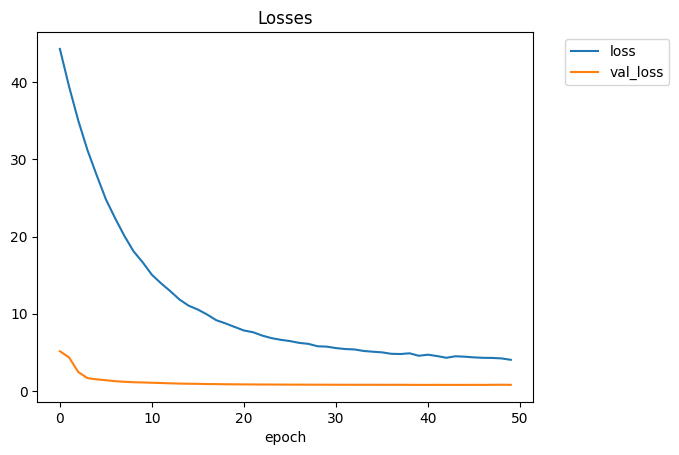

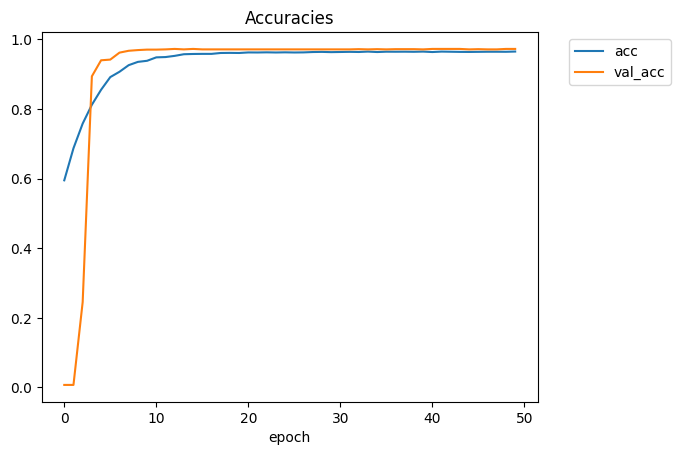

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(1500, 5)


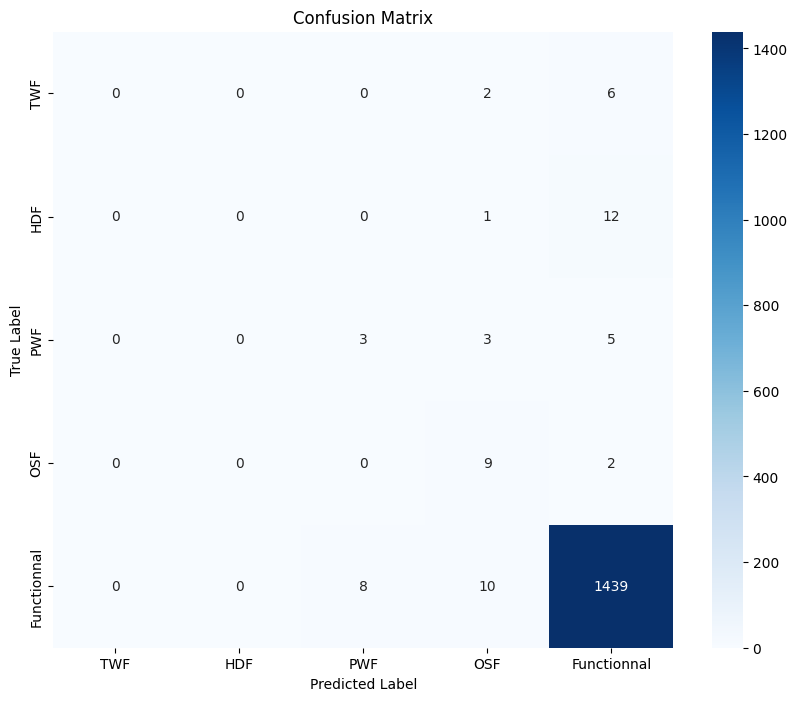

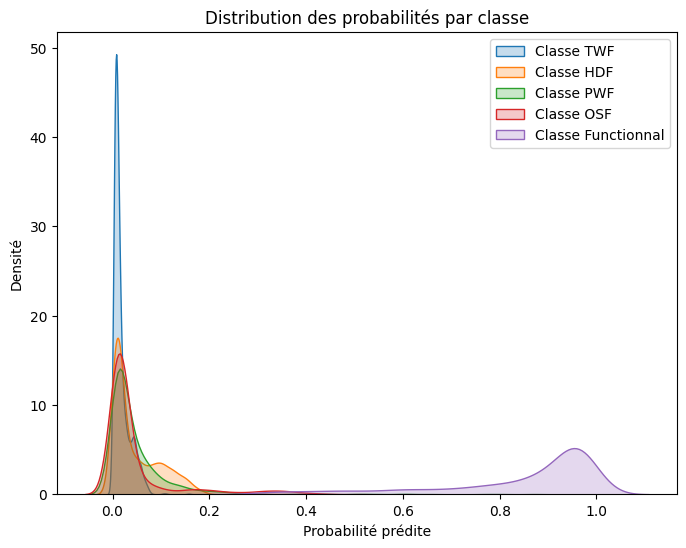

              precision    recall  f1-score   support

         TWF       0.00      0.00      0.00         8
         HDF       0.00      0.00      0.00        13
         PWF       0.27      0.27      0.27        11
         OSF       0.36      0.82      0.50        11
 Functionnal       0.98      0.99      0.99      1457

    accuracy                           0.97      1500
   macro avg       0.32      0.42      0.35      1500
weighted avg       0.96      0.97      0.96      1500



c:\Users\rabie\OneDrive\Bureau\ISMIN 2A\S8\Embeded_AI\embeded_ia\ai_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rabie\OneDrive\Bureau\ISMIN 2A\S8\Embeded_AI\embeded_ia\ai_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rabie\OneDrive\Bureau\ISMIN 2A\S8\Embeded_AI\embeded_ia\ai_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

In [18]:
display_training_curves(training_history_weighted)

#Predictions
Y_pred_probs = unbalanced.predict(X_valid) # Get probability predictions
Y_pred = np.argmax(Y_pred_probs, axis=1) # Convert to class labels
Y_true = np.argmax(Y_valid, axis=1)
print(Y_valid.shape)

##Problème : on perd une classe ce qui empêche d'avoir une bonne matrice de confusion et d'obtenir le report => une classe ne serait pas représenté dans la Y_valid alors que la shape est bien (1500,5)


#Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=output_labels, yticklabels=output_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


#Probability distribution for each class
plt.figure(figsize=(8,6))
for i in range(5):
    sns.kdeplot(Y_pred_probs[:, i], label=f'Classe {output_labels[i]}', fill=True)

plt.xlabel("Probabilité prédite")
plt.ylabel("Densité")
plt.title("Distribution des probabilités par classe")
plt.legend()
plt.show()


#Report
report = classification_report(Y_true, Y_pred, target_names=output_labels)
print(report)

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"